# AIML426 Project 1
## Genetic Agorithm for 0-1 Knapsack problem

This is the report for the AIML426 project 1, discussing the genetic algorithm for solving the 0-1 Knapsack problem.  This report refers to code in a script 'knapsack_mod.py' that draws heavily on the source code provided for the same example problem at:  
https://github.com/DEAP/deap/blob/master/examples/ga/knapsack.py

### Problem description  

The knapsack problem is a multi-objective optimisation problem that seeks to determine the most valuable mix of items to carry (with value $v_i$ and weight $w_i$) in a knapsack that has a weight constraint $(Q)$.  The problem description can be represented as:  

\begin{aligned}
\text{max } v_1x_1 + v_2 x_2 + ... + v_Mx_M,\\
\text{s.t. } w_1x_1 + w_2x_2 + ... + w_Mx_M \le Q, \\
x_i \in \{0, 1\}, i = 1, ..., M
\end{aligned}

where $x_i=1$ means that item $i$ is selected, and $x_i = 0$ means that item $i$ is not selected.

### Method description  

The overall process for this script, closely follows that of the example script:  

1. Create the Individual class  
    - define fitness attributes and objective function:  
        -- 'value': maximise  
        -- 'weight': minimise  
2. Initialise a population of Individuals  
    - represent individuals as N-bit binary, N = number of items  
    - generate desired population of individuals  
3. Evaluate individuals in the population  
    - determine each individual's total 'value' and 'weight'  
    - invalidate individuals over over maximum weight  
4. Generate a new population by selection or mutation  
    - generate offspring using single point crossover  
    - mutate some of the offspring using the flip-bit mutation  
5. Repeat steps 3 and 4 until end or convergence  

### individual representation  

I represented the individual as N-bit binary list, with N = number of total items.  Each bit represented an individual item, with 0 indicating the item is excluded the knapsack and 1 indicating the item is included in the knapsack.  For me, this made a better logical representation of the individual in relation to the problem - do I carry an item or not.  I considered retaining the approach used in the example - a 'set' of integer values representing the index of each item to be carried in the knapsack - while that made sense in terms of the python object, I preferred the in-out representation of the N-bit binary list.

### fitness function

I modified the fitness function provided in the deap example to take the 'value' and 'weight' of a particular item and multiply it by the binary bit, or indicator, for each item's corresponding bit in the individual.  So if an individual includes a particular item, the item's indicator = 1 and the item's 'value' and 'weight' will be added to the total.  If the item's indicator is 0, then the 'value' and 'weight' will also multiply to zero, and not be added to the total.  

If the weight of the knapsack exceeds the maximum weight then the individual's fitness is set to 'value' = 0, and 'weight' = 10,000.  Because the objective functions each aim to maximise 'value' and minimise 'weight', these individuals are effectively invalidated.

\begin{align*}
\text{val} & = \sum^n_{i=1} v_i I_i\\
\text{wt} & = \sum^n_{i=1} w_i I_i\\
\text{if wt } & > W_{max} \text{ then } \text{val} \to 0, \text{and wt} \to 10000
\end{align*}

where:

$ n =$ number of items available  
$ v_i =$ value of the $i$ th item  
$ w_i =$ weight of the $i$ th item  
$I_i \in \{0, 1\}$ is the indicator for the $i$ th item: $0=$ item excluded from the knapsack, $1=$ item included in the knapsack
val = the total value of items in the knapsack
wt = the total weight of items in the knapsack
$W_{max} =$ maximum weight capacity of the knapsack

I used this function because it was reasonably straight-forward to implement and provided the most directly representative fitness for each individual. Note, that while this approach was effective for the first two knapsack problems, it forced the inclusion of an initial population with mostly empty individuals to reduce the likelihood of overweight knapsacks saturating the population.

### initialisation  

My initialisation included the creation of an 'Individual' container, of class 'list', which inherited a multi-objective fitness class.  Each instance of the Individual class, drew a random binary value, N-times.  Each population comprised the desired number of instantiated individuals, with the initial population being 5*N (where N is the number of items) and the second and subsequent generations being twice this size.

Because the third knapsack problem had many high-weight items, I included a heavy bias towards generating an initial population of individuals that had very few items present.  I set a proportion of 9:1 that an item would be excluded, so individuals in the first population had mostly empty knapsacks (i.e. 90 of 100 items would be excluded from the knapsack).  Without this bias, the population and each subsequent evolution quickly saturated with invalid individuals and it was almost impossible for valid individuals to develop once that occurred.  This bias had no visible impact on the other two knapsack problems, which both achieved close to optimal results regardless of the make up of the first generation of individuals.

This method allowed for creation of individual's according to a parameter (N = total number of items), providing flexibility for responding to a range of different-sized item lists and knapsack limits, albeit defined by the layout of provided data.

### parent and environment selection

I opted for the built in selBest selection method because it consistently resulted in better performance, at the expense of diversity in later generations.  This method selects the best individuals from the parent population, to increase the probability that those best parents can pass on their genes, resulting in better performance in fewer generations

Contrast this method with, say, the NSGA2 method, which tended to result in more diverse generations but those generations never seemed to get as close to the optimal knapsack, even after all evolutions have passed.

My algorithm selection (eaMuPlusLambda) was driven mostly by the third knapsack problem.  While the first two knapsacks would reach convergence with most algorithms, the third knapsack problem became saturated with invalid individuals almost from the outset when using eaMuCommaLambda, where the next generation is selected __only__ from the children produced by the VarOr function (i.e. results of crossover, or mutation, or remaining parent individuals).  Thus, the next generation has a lower proportion of mostly-empty knapsacks than a generation selected (as in eaMuPlusLambda) from both the parent (which has a high proportion of mostly-empty knapsacks) __and__ the offspring which should also have a high proportion of mostly empty knapsacks (i.e. only the mutated individuals should have additional items included).  

### crossover and mutation operators  

I used the cxUniform method, with a probability of 0.4 that a crossover would occur between parents for any particular attribute (gene or bit).  I used the mutFlipBit method, with a probability of 0.4 that any particular attribute would be flipped.  I set the probability that an individual would be selected for crossover at 0.6, or for  mutation at 0.4.  

I chose these particular methods because they seemed well suited to the binary attributes I used for the individual representation.  Other crossover methods I considered were one and two point crossover because they created offspring of the same size as the parents, ensuring the best chance for optimising the knapsack (i.e. every item was represented).  

I avoided methods that expected the individual representations as floating points because these resulted in offspring with floating point attributes, which represent incomplete (i.e. 0 > 'attr' > 1) or multiple (i.e. 'attr' > 1) individual items. 

### parameters  

I used experiments with a total of 50 generations, initialising with 5*N (where N = number of items) individuals in the first population and twice as many individuals in the second and subsequent generations.  

I included default parameters for the number of generations (NGEN = 50), the size of the Hall of Fame (HOF_MAX = 10).  I preferred crossover (CXPB = 0.6) over mutation (MUTPB = 0.4), primarily as a result of tuning for the third knapsack problem that a high proportion of high-weight items and was only successful after evolving from initial populations of mostly empty knapsacks.  When performing either Uniform cross-over or FlipBit mutation, I set the probability at 0.4 for each gene (thus, 40% of the genes in an pair selected for crossover would be swapped and 40% of the genes in an individual selected for mutation would be flipped).

Most parameters were selected based on their impact on the third knapsack problem, which started with mostly-empty knapsacks.  The main strategy was to limit the quantity of items in any individual so after starting with a population of mostly-empty knapsacks, I was more interested in moving few items between individuals (i.e. crossover) than in having mostly-empty knapsacks have more items added (i.e. mutating), so I had a higher crossover than mutation rate.  Similarly, the relatively low probability of an individual gene being selected for crossover or mutation (0.4) was chosen to slow the rate that mostly-empty knapsacks fill with new items, while still allowing convergence to close to optimal levels, and this convergence was present across all three knapsack problems.

### Experiment 

For each knapsack problem, run the algorithm 5 times with different random seeds and obtain a best solution for each.  Present a table with the total value and total weight of best solutions and the mean and standard deviation fo the 5 totals.

In [1]:
import knapsack_mod as ks
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import pandas as pd

# references to datafiles
knapsack_data = ['10_269', '23_10000', '100_995']


ks_mods = ['', 
           'ALGO = algorithms.eaMuCommaLambda', 
           'EMPTY = 0.4']
modified = []
for m, mod in enumerate(ks_mods):

    # run the experiment
    experiment = []  # object to hold five runs of each batch
    for k, knap in enumerate(knapsack_data):
        run = []
        for r in range(5):  # five runs per knapsack
            pop, stat, log = ks.main(knap, mod)
            run.append(stat)

        experiment.append(run)  # 1m 11s
    modified.append(experiment)

/home/chad/2024 VUW/AIML426/AIML426A1/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/chad/2024 VUW/AIML426/AIML426A1/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/chad/2024 VUW/AIML426/AIML426A1/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/chad/2024 VUW/AIML426/AIM

### Create plots  

Create plots for each knapsack problem, showing the top performing individuals in each generation, for each run.  Fitness is shown in total value for each individual.  Plots are separated by knapsack problem (i.e. number of items).  

In [2]:
# create a function to generate plots and table for comparing results

def knap_results(experiment, id='original'):
    f_title = 'Best fitness by generation: '+ id
    
    # create plots and tables for displaying results
    fig, axs = plt.subplots(1, len(experiment))
    fig.set_tight_layout('constrained')
    fig.suptitle(f_title)
    fig.supylabel('fitness: value')

    finals = pd.DataFrame(index = ['run 1', 'run 2', 'run 3', 'run 4', 'run 5', 'mean', 'std dev'],
                        columns = knapsack_data)    

    for k,knap in enumerate(experiment):
        axs[k].set_title(knapsack_data[k])
        
        for r, run in enumerate(knap):
            line_lab = 'run '+str(r+1)
            best_in_gen = []
            
            for g, gen in enumerate(run):
                best_in_gen.append(knap[r][g]['max'][0])
            
            # add best individuals to the plot
            axs[k].plot(best_in_gen,
                    label = line_lab)
            axs[k].set_xlabel("Generation")
            axs[k].legend(loc = 'lower right')

            # add best individual to the dataframe
            finals.iloc[r, k] = knap[r][50]['max'][0]
        
        # calculate total, mean and standard deviation across the five runs
        finals.iloc[5, k] = np.mean(finals.iloc[:5, k])
        finals.iloc[6, k] = np.std(finals.iloc[:5, k])

    # output the table and plot
    print(finals) # output table?
    plt.show()  # save to file?


For the implemented genetic algorithm, convergence is achieved fairly early for the knapsack with 10 items (usually within the first half), much earlier for the knapsack with 23 items (within the first 10 generations) and was not reached for some of the runs in the knapsack with 100 possible items.  For both the 10 and 23 item knapsack problems, a fitness value equivalent to the optimum was achieved across all five runs.  For the 100 item knapsack problem,  high-performing individuals are usually produced, but not all runs produce an individual that achieves the optimum fitness of 1514.

        10_269 23_10000 100_995
run 1    295.0   9767.0  1512.0
run 2    295.0   9767.0  1512.0
run 3    295.0   9767.0  1512.0
run 4    295.0   9767.0  1513.0
run 5    295.0   9767.0  1512.0
mean     295.0   9767.0  1512.2
std dev    0.0      0.0     0.4


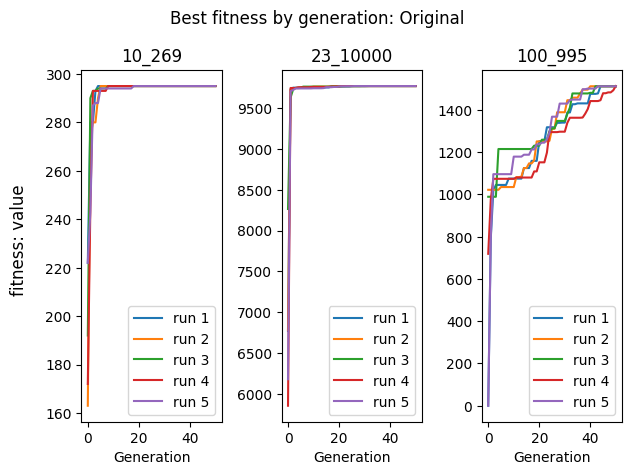

        10_269 23_10000    100_995
run 1    295.0   9767.0     1501.0
run 2    295.0   9763.0     1513.0
run 3    295.0   9767.0     1464.0
run 4    295.0   9767.0     1512.0
run 5    295.0   9767.0     1496.0
mean     295.0   9766.2     1497.2
std dev    0.0      1.6  17.814601


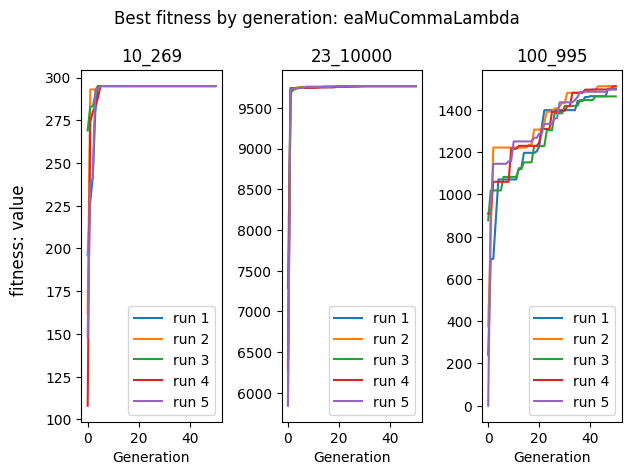

        10_269 23_10000    100_995
run 1    295.0   9767.0     1432.0
run 2    295.0   9767.0     1497.0
run 3    295.0   9767.0     1512.0
run 4    295.0   9767.0     1512.0
run 5    295.0   9767.0     1481.0
mean     295.0   9767.0     1486.8
std dev    0.0      0.0  29.701178


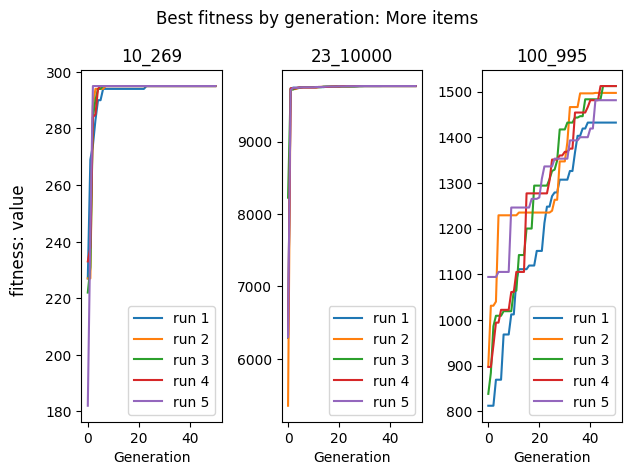

In [3]:
# output the results for the three versions
ks_mod_results = ['Original', 'eaMuCommaLambda', 'More items']
for i, exp in enumerate(modified):
    knap_results(exp, ks_mod_results[i])

### Make modifications  

Repeating the experiment with minor modifications:  

  - mod1: change algorithm from eaMuPlusLambda to eaMuCommaLambda
  - mod2:  increase the number of items in initial individuals

Based on testing during development, these modifications are not expected to have signficant impact on the results of the 10 and 23 item knapsack problems.  I expect worse performance for both modifications on the 100 item knapsack problem, as the increased number of items present in each individual, also increases the likelihood that over-weight, invalid individuals saturate the model.

Across the three modified experiments, the results are consistent for the 10 item and 23 item knapsack problems, i.e. convergence is reached fairly quickly and the optimum value is achieved for both knapsacks, with all modifications to the generational algorithm.  For the 100 item knapsack problem, there is variation between the modified experiments, although this level of variation was also observed during testing when running the same experiment, so it is unclear if the variation is a result of the modifications.  

I expected lower performance when using the eaMuCommaLambda algorithm as new individual's are only selected from the crossed and mutated offspring, which increases the effect of mutation (i.e. since the majority of chromosomes are 0 in the early generations, then the number of items added to individuals in subsequent generations increases earlier).  Based on the plotted results for the 100 item knapsack, the eaMuCommaLamba algorithm took slightly longer to begin generating better performing individuals

I also expected lower performance when increasing the number of items initialising in early individual knapsacks.  Because the 100 item knapsack problem has many high-weighted items, it was difficult during early development for the algorithm to recover from populations with individuals that had a high number of items.  The algorithm with more items performed better than I expected (based on my development and testing), the algorithm produced better solutions earlier than the original and the eaMuCommaLambda versions, presumably as a result of the greater probability of having knapsacks with items, and therefore value, generated.  

Convergence for the 100 item knapsack was slower across all variations (original, eaMuCommaLambda, more_items) than for the other two knapsack problems, and in most runs, convergence wasn't obviously achieved.  Potentially, a greater number of generations may have achieved convergence for the 100 item knapsack problem.

### overall conclusion  

The change in algorithm (from eaMuPlusLambda to eaMuCommaLambda) had little effect on the overall performance.  The increase in items within the initial individuals also had a surprisingly small effect.  And that's when it hit me.  When I was initially developing my algorithm, the 100 item knapsack was routinely saturated with invalid individuals.  I managed to finally get some useful results when I increased the likelihood of empty knapsacks for the initial population, and that intervention stuck in my head as the silver bullet.  

But what I did in subsequent testing and tweaking was to reduce the ratio of mutation to crossover (mostly crossover) and the likelihood of mutation or crossover on a single chromosome (to 0.4), so the rate of evolution was fairly slow, but always towards optimal knapsacks. 

## Genetic Algorithm for Feature Selection